In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

### Scraping Fuel Price

In [2]:
import csv
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException
from datetime import datetime
import time

# ChromeDriver setup
chrome_driver_path = "C:\\chromedriver-win64\\chromedriver.exe"
options = webdriver.ChromeOptions()
# options.add_argument("--headless")  # Uncomment to hide browser
service = Service(executable_path=chrome_driver_path)
driver = webdriver.Chrome(service=service, options=options)

# Go to the CEYPETCO historical prices page
url = "https://ceypetco.gov.lk/historical-prices/"
driver.get(url)
time.sleep(2)

lad_prices = []

def extract_from_current_page():
    table = driver.find_element(By.TAG_NAME, "table")
    rows = table.find_elements(By.TAG_NAME, "tr")

    for row in rows[1:]:
        cells = row.find_elements(By.TAG_NAME, "td")
        if len(cells) >= 4:
            date_str = cells[0].text.strip()
            lad_price = cells[3].text.strip()

            try:
                date_obj = datetime.strptime(date_str, "%d.%m.%Y")
                if date_obj >= datetime(2024, 1, 1):
                    lad_prices.append({
                        'date': date_obj.strftime("%Y-%m-%d"),
                        'lad_price': lad_price
                    })
            except ValueError:
                continue

# Find all page numbers
pagination = driver.find_elements(By.XPATH, "//a[@data-page]")
page_numbers = sorted(set(int(p.get_attribute("data-page")) for p in pagination))

for page in page_numbers:
    print(f"Scraping page {page}...")
    try:
        page_link = driver.find_element(By.XPATH, f"//a[@data-page='{page}']")
        driver.execute_script("arguments[0].click();", page_link)
        time.sleep(2)
        extract_from_current_page()
    except NoSuchElementException:
        print(f"Page {page} not found, skipping.")

driver.quit()

# Sort data
lad_prices.sort(key=lambda x: x['date'], reverse=True)

# Save to CSV
csv_filename = "feul_price.csv"
with open(csv_filename, mode="w", newline="", encoding="utf-8") as file:
    writer = csv.DictWriter(file, fieldnames=["date", "lad_price"])
    writer.writeheader()
    writer.writerows(lad_prices)

print(f"\n✅ Data saved to '{csv_filename}'")


Scraping page 1...
Scraping page 2...
Scraping page 3...
Scraping page 4...
Scraping page 5...
Scraping page 6...
Scraping page 7...
Scraping page 8...
Scraping page 9...
Scraping page 10...
Scraping page 11...
Scraping page 12...
Scraping page 13...
Scraping page 14...
Scraping page 15...
Scraping page 16...
Scraping page 17...

✅ Data saved to 'feul_price.csv'


### Scraping Exchange Rate

In [3]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
import pandas as pd
import time

# Setup WebDriver
print("🚀 Launching browser...")
service = Service('C:/chromedriver-win64/chromedriver.exe')  # Update path if needed
driver = webdriver.Chrome(service=service)

try:
    print("🌐 Opening CBSL exchange rates page...")
    driver.get('https://www.cbsl.gov.lk/en/rates-and-indicators/exchange-rates/daily-indicative-exchange-rates')
    wait = WebDriverWait(driver, 50)

    # Step 1: Locate and switch through iframes to find the one with the date input
    print("🧭 Locating and checking all iframes...")
    iframe_list = driver.find_elements(By.TAG_NAME, "iframe")
    print(f"🔍 Found {len(iframe_list)} iframe(s)")

    date_iframe = None
    for i, iframe in enumerate(iframe_list):
        print(f"🔁 Switching to iframe {i+1}")
        driver.switch_to.default_content()
        driver.switch_to.frame(iframe)
        try:
            date_input = WebDriverWait(driver, 5).until(
                EC.presence_of_element_located((By.ID, "txtStart"))
            )
            date_iframe = iframe
            print(f"✅ Date input field found in iframe {i+1}")
            break
        except:
            print(f"❌ Date input field not found in iframe {i+1}")
            continue

    if date_iframe is None:
        raise Exception("❌ Date input field not found in any iframe!")

    # Step 2: Interact with the date picker
    print("📅 Interacting with the date picker...")
    date_input.click()
    time.sleep(1)

    caption = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.XPATH, "//td[@class='dp_caption']"))
    )
    caption.click()
    print("✅ Caption clicked")

    previous_month_button = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.XPATH, "//td[@class='dp_previous']"))
    )
    previous_month_button.click()
    print("✅ Previous month clicked")

    january_selector = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.XPATH, "//td[@class='dp_month_0']"))
    )
    january_selector.click()
    print("✅ January selected")

    day_selector = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.XPATH, "//td[text()='1']"))
    )
    day_selector.click()
    print("✅ Day 1 selected")

    print("📅 Date selected successfully!")

    # Step 3: Uncheck EUR and JPY (same iframe)
    print("🔍 Locating EUR checkbox...")
    eur_checkbox = wait.until(EC.presence_of_element_located((By.XPATH, "//input[@value='EUR~Euro']")))
    if eur_checkbox.is_selected():
        eur_checkbox.click()
        print("☑️ Unchecked EUR")
    else:
        print("✅ EUR already unchecked")

    print("🔍 Locating JPY checkbox...")
    jpy_checkbox = wait.until(EC.presence_of_element_located((By.XPATH, "//input[@value='JPY~Japanese Yen']")))
    if jpy_checkbox.is_selected():
        jpy_checkbox.click()
        print("☑️ Unchecked JPY")
    else:
        print("✅ JPY already unchecked")

    # Step 4: Submit the form
    print("📤 Submitting the form...")
    submit_button = wait.until(EC.element_to_be_clickable((By.NAME, 'submit_button')))
    submit_button.click()

    # Step 5: Wait for results and extract
    print("⏳ Waiting for results...")
    wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'table')))
    time.sleep(2)
    print("✅ Results table loaded")

    table = driver.find_element(By.XPATH, "//table[contains(@class,'table')]")
    rows = table.find_elements(By.TAG_NAME, "tr")

    if not rows:
        raise Exception("❌ No rows found.")

    headers = [th.text.strip() for th in rows[0].find_elements(By.TAG_NAME, "th")]
    data = [[td.text.strip() for td in row.find_elements(By.TAG_NAME, "td")] for row in rows[1:]]

    df = pd.DataFrame(data, columns=headers)
    print("📄 DataFrame preview:")
    print(df.head())

    df.to_csv("cbsl_exchange_rates.csv", index=False)
    print("💾 Data saved to cbsl_exchange_rates.csv")

finally:
    print("🧹 Closing browser...")
    driver.quit()


🚀 Launching browser...
🌐 Opening CBSL exchange rates page...
🧭 Locating and checking all iframes...
🔍 Found 3 iframe(s)
🔁 Switching to iframe 1
❌ Date input field not found in iframe 1
🔁 Switching to iframe 2
❌ Date input field not found in iframe 2
🔁 Switching to iframe 3
✅ Date input field found in iframe 3
📅 Interacting with the date picker...
✅ Caption clicked
✅ Previous month clicked
✅ January selected
✅ Day 1 selected
📅 Date selected successfully!
🔍 Locating EUR checkbox...
☑️ Unchecked EUR
🔍 Locating JPY checkbox...
☑️ Unchecked JPY
📤 Submitting the form...
⏳ Waiting for results...
✅ Results table loaded
📄 DataFrame preview:
         Date 1 USD -> LKR 1 LKR -> USD
0  2025-04-23     299.7194       0.0033
1  2025-04-22     299.2328       0.0033
2  2025-04-21     299.0786       0.0033
3  2025-04-17     298.6186       0.0033
4  2025-04-16     298.1380       0.0034
💾 Data saved to cbsl_exchange_rates.csv
🧹 Closing browser...


### Scraping CCPI

In [4]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import requests
import urllib3
import time
import fitz  # PyMuPDF
import pandas as pd
import os
import re

from pdf2image import convert_from_path
import pytesseract

# 🔧 Path to Tesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# 🔧 Disable SSL warnings
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# WebDriver config
chrome_driver_path = "C:\\chromedriver-win64\\chromedriver.exe"
options = webdriver.ChromeOptions()
options.headless = False
driver = webdriver.Chrome(service=Service(chrome_driver_path), options=options)

# Visit CBSL page
url = "https://www.cbsl.gov.lk/en/measures-of-consumer-price-inflation"
driver.get(url)
print("Waiting for the page to load...")
time.sleep(5)

# Get inflation report links
inflation_links = WebDriverWait(driver, 10).until(
    EC.presence_of_all_elements_located((By.PARTIAL_LINK_TEXT, "Inflation"))
)

# Use the latest report
first_link = inflation_links[0]
print(f"\n📄 Processing report: {first_link.text.strip()}")
first_link.click()
time.sleep(3)

# Find PDF link
pdf_elements = WebDriverWait(driver, 10).until(
    EC.presence_of_all_elements_located((By.XPATH, "//a[contains(@href, '.pdf')]"))
)

pdf_url = None
for el in pdf_elements:
    href = el.get_attribute("href")
    if "inflation" in href.lower() and "ccpi" in href.lower():
        pdf_url = href
        break

if not pdf_url:
    print("❌ No PDF link found.")
    driver.quit()
    exit()

print(f"📎 PDF URL: {pdf_url}")

# Download PDF
pdf_response = requests.get(pdf_url, verify=False)
local_pdf_path = "temp_report.pdf"
if pdf_response.status_code == 200:
    with open(local_pdf_path, 'wb') as f:
        f.write(pdf_response.content)
    print(f"✅ PDF downloaded: {local_pdf_path}")
else:
    print("❌ Failed to download PDF.")
    driver.quit()
    exit()

# Read page 2 text
doc = fitz.open(local_pdf_path)
page_text = doc[1].get_text() if len(doc) >= 2 else ""
doc.close()

if not page_text.strip():
    print("⚠️ No extractable text. Using OCR...")
    images = convert_from_path(local_pdf_path, first_page=2, last_page=2)
    if images:
        page_text = pytesseract.image_to_string(images[0])

os.remove(local_pdf_path)

# Process lines to extract Year, Month, CCPI
lines = [line.strip() for line in page_text.split('\n') if line.strip()]
current_year = ""
data = []
months = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]

i = 0
while i < len(lines):
    line = lines[i]
    # Detect Year
    year_match = re.match(r'20\d{2}', line)
    if year_match:
        current_year = year_match.group()
        i += 1
        continue

    # Detect Month + CCPI pattern
    month_match = next((m for m in months if m in line), None)
    if current_year and month_match:
        # Try to find CCPI as a float after month
        ccpi_match = re.search(rf"{month_match}\s+(\d{{3}}\.\d)", line)
        if not ccpi_match and (i + 1 < len(lines)):
            # Try in the next line
            ccpi_match = re.match(r"(\d{3}\.\d)", lines[i + 1])
            if ccpi_match:
                ccpi_value = ccpi_match.group(1)
                data.append([current_year, month_match, ccpi_value])
                i += 2
                continue
        elif ccpi_match:
            ccpi_value = ccpi_match.group(1)
            data.append([current_year, month_match, ccpi_value])
            i += 1
            continue

    i += 1

# Filter from January 2024 onward
filtered_data = [row for row in data if not (
    int(row[0]) < 2024 or (row[0] == "2024" and months.index(row[1]) < months.index("January"))
)]

# Save to CSV with Date column
if filtered_data:
    df = pd.DataFrame(filtered_data, columns=["Year", "Month", "CCPI"])

    # Create Date column
    month_map = {
        "January": "01", "February": "02", "March": "03", "April": "04",
        "May": "05", "June": "06", "July": "07", "August": "08",
        "September": "09", "October": "10", "November": "11", "December": "12"
    }
    df["Date"] = df.apply(lambda row: f"{row['Year']}/{month_map[row['Month']]}/01", axis=1)

    df.to_csv("cbsl_ccpi.csv", index=False)
    print("\n✅ Extracted Data:")
    print(df.to_string(index=False))
    print("\n✅ Saved to cbsl_ccpi_cleaned.csv")
else:
    print("❌ No valid CCPI data found.")

driver.quit()


Waiting for the page to load...

📄 Processing report: Inflation in March 2025 - CCPI
📎 PDF URL: https://www.cbsl.gov.lk/sites/default/files/cbslweb_documents/press/pr/press_20250328_inflation_in_march_2025_ccpi_e.pdf
✅ PDF downloaded: temp_report.pdf

✅ Extracted Data:
Year     Month  CCPI       Date
2024     March 196.7 2024/03/01
2024     April 195.2 2024/04/01
2024       May 194.1 2024/05/01
2024      June 195.6 2024/06/01
2024      July 194.7 2024/07/01
2024    August 191.1 2024/08/01
2024 September 190.9 2024/09/01
2024   October 189.9 2024/10/01
2024  November 189.4 2024/11/01
2024  December 191.7 2024/12/01
2025   January 192.6 2025/01/01
2025  February 192.2 2025/02/01
2025     March 191.6 2025/03/01

✅ Saved to cbsl_ccpi_cleaned.csv


### Scraping vegitable prices

In [5]:
import requests
import fitz  # PyMuPDF
import csv
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import re

# Path to your local chromedriver
chromedriver_path = "C:\\chromedriver-win64\\chromedriver.exe"

# Set up Selenium WebDriver
options = Options()
options.headless = False
service = Service(chromedriver_path)
driver = webdriver.Chrome(service=service, options=options)

# Open the URL
url = "https://www.cbsl.gov.lk/en/statistics/economic-indicators/price-report"
driver.get(url)

# Find the PDF link
first_pdf_link = driver.find_element(
    By.XPATH, "//a[contains(@href, 'price_report') and contains(@href, '.pdf')]"
).get_attribute("href")

print(f"The first Daily Price Report PDF link is: {first_pdf_link}")

# Download PDF
pdf_response = requests.get(first_pdf_link, verify=False)
pdf_path = "daily_price_report.pdf"
with open(pdf_path, 'wb') as f:
    f.write(pdf_response.content)

# Extract second page text
doc = fitz.open(pdf_path)
page = doc.load_page(1)
page_text = page.get_text("text")

# Close browser and doc
driver.quit()
doc.close()

# Process the text
lines = [line.strip() for line in page_text.split("\n") if line.strip()]

# Regex pattern to find the date in the header (assumes date format like "17 April 2025")
date_pattern = r"\d{1,2}\s\w+\s\d{4}"

# Search for the date in the text
date_match = re.search(date_pattern, page_text)

# If a date is found, use it. If not, default to "Unknown"
date = date_match.group() if date_match else "Unknown"

# CSV output
csv_filename = "price_report.csv"
with open(csv_filename, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(["Item", "Unit", "Yesterday Price", "Today Price", "Date"])

    # Extracting the data
    i = 0
    while i < len(lines) - 3:
        item = lines[i]
        unit_line = lines[i + 1]
        yesterday_price_line = lines[i + 2]
        today_price_line = lines[i + 3]

        if "Rs./" in unit_line:
            unit = unit_line
            yesterday_price = yesterday_price_line.split()[0] if yesterday_price_line.split() else "n.a."
            today_price = today_price_line.split()[0] if today_price_line.split() else "n.a."
            writer.writerow([item, unit, yesterday_price, today_price, date])
            i += 4  # Move to next block
        else:
            i += 1  # Skip if format doesn't match

print(f"\n✅ CSV with item, unit, yesterday price, today price, and date saved as: {csv_filename}")


The first Daily Price Report PDF link is: https://www.cbsl.gov.lk/sites/default/files/cbslweb_documents/statistics/pricerpt/price_report_20250422_e.pdf

✅ CSV with item, unit, yesterday price, today price, and date saved as: price_report.csv


#### Create Data set

In [6]:
df = pd.read_csv('CropPriceNew.csv')
df1 = pd.read_csv('feul_price.csv')
df2 = pd.read_csv('cbsl_exchange_rates.csv')
df3 = pd.read_csv('cbsl_ccpi.csv')
df4 = pd.read_csv('price_report.csv')

In [7]:
df.head()

,Date,ExchangeRate,HeadlineInflation,FuelPrice(Diesel),Beans,Carrot,Cabbage,Tomato,Brinjal,Pumpkin,Snake gourd,Green Chilli,Red Onion (Local),Potato (Local),Red Dhal,Banana (Sour),Papaw
0,2024-01-01,323.9902,200.7,358.0,450.0,550.0,450.0,400.0,700.0,150.0,200.0,1250.0,350.0,353.0,300.0,200.0,120.0
1,2024-01-02,323.1861,200.7,358.0,550.0,700.0,500.0,600.0,450.0,150.0,200.0,1300.0,500.0,360.0,300.0,200.0,180.0
2,2024-01-03,321.1200,200.7,358.0,500.0,700.0,450.0,600.0,550.0,150.0,200.0,1300.0,500.0,363.0,300.0,200.0,180.0
3,2024-01-04,322.2375,200.7,358.0,450.0,750.0,400.0,550.0,600.0,150.0,180.0,1100.0,500.0,358.0,300.0,200.0,180.0
4,2024-01-05,322.4275,200.7,358.0,450.0,700.0,430.0,550.0,550.0,150.0,180.0,1000.0,500.0,330.0,300.0,200.0,180.0


In [8]:
df.shape

(479, 17)

In [9]:
df1.head()

,date,lad_price
0,2025-04-01,286.0
1,2025-02-01,286.0
2,2025-01-01,286.0
3,2024-12-05,286.0
4,2024-12-01,286.0


In [10]:
df2.head()

,Date,1 USD -> LKR,1 LKR -> USD
0,2025-04-23,299.7194,0.0033
1,2025-04-22,299.2328,0.0033
2,2025-04-21,299.0786,0.0033
3,2025-04-17,298.6186,0.0033
4,2025-04-16,298.1380,0.0034


In [11]:
df3.head()

,Year,Month,CCPI,Date
0,2024,March,196.7,2024/03/01
1,2024,April,195.2,2024/04/01
2,2024,May,194.1,2024/05/01
3,2024,June,195.6,2024/06/01
4,2024,July,194.7,2024/07/01


In [12]:
df4.head()

,Item,Unit,Yesterday Price,Today Price,Date
0,Beans,Rs./kg,400.00,400.00,22 April 2025
1,Carrot,Rs./kg,350.00,450.00,22 April 2025
2,Cabbage,Rs./kg,200.00,250.00,22 April 2025
3,Tomato,Rs./kg,400.00,550.00,22 April 2025
4,Brinjal,Rs./kg,400.00,350.00,22 April 2025


In [13]:
# df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')  # or '%d/%m/%Y' if needed
# df = df.sort_values('Date', ascending=False).reset_index(drop=True)
# df.head()

df['Date'] = pd.to_datetime(df['Date'])  # No need for format if ISO
df = df.sort_values('Date', ascending=True).reset_index(drop=True)


In [14]:
# Step 1: Convert both date columns to datetime
df['Date'] = pd.to_datetime(df['Date'])
df1['date'] = pd.to_datetime(df1['date'])

# Step 2: Set 'Date' as index for df and 'date' as index for df1 (makes updating easier)
df.set_index('Date', inplace=True)
df1.set_index('date', inplace=True)

# Step 3: Update existing dates and add new ones
df.update(df1.rename(columns={'lad_price': 'FuelPrice(Diesel)'}))  # Replace matching dates
df = pd.concat([df, df1.rename(columns={'lad_price': 'FuelPrice(Diesel)'})[~df1.index.isin(df.index)]])  # Add missing dates

# Step 4: Reset index and sort (optional)
df = df.reset_index().rename(columns={'index': 'Date'})
df = df.sort_values('Date', ascending=True).reset_index(drop=True)
df.head()

,Date,ExchangeRate,HeadlineInflation,FuelPrice(Diesel),Beans,Carrot,Cabbage,Tomato,Brinjal,Pumpkin,Snake gourd,Green Chilli,Red Onion (Local),Potato (Local),Red Dhal,Banana (Sour),Papaw
0,2024-01-01,323.9902,200.7,358.0,450.0,550.0,450.0,400.0,700.0,150.0,200.0,1250.0,350.0,353.0,300.0,200.0,120.0
1,2024-01-02,323.1861,200.7,358.0,550.0,700.0,500.0,600.0,450.0,150.0,200.0,1300.0,500.0,360.0,300.0,200.0,180.0
2,2024-01-03,321.1200,200.7,358.0,500.0,700.0,450.0,600.0,550.0,150.0,200.0,1300.0,500.0,363.0,300.0,200.0,180.0
3,2024-01-04,322.2375,200.7,358.0,450.0,750.0,400.0,550.0,600.0,150.0,180.0,1100.0,500.0,358.0,300.0,200.0,180.0
4,2024-01-05,322.4275,200.7,358.0,450.0,700.0,430.0,550.0,550.0,150.0,180.0,1000.0,500.0,330.0,300.0,200.0,180.0


In [15]:
# Step 1: Convert date columns to datetime
df2['Date'] = pd.to_datetime(df2['Date'])
df['Date'] = pd.to_datetime(df['Date'])  # Just to be safe again

# Step 2: Set index for easy merging
df.set_index('Date', inplace=True)
df2.set_index('Date', inplace=True)

# Step 3: Update ExchangeRate where dates match
df.update(df2.rename(columns={'1 USD -> LKR': 'ExchangeRate'}))  # Replace existing

# Step 4: Add missing dates from df2
missing_dates = df2[~df2.index.isin(df.index)]
missing_dates = missing_dates[['1 USD -> LKR']].rename(columns={'1 USD -> LKR': 'ExchangeRate'})
df = pd.concat([df, missing_dates], axis=0)

# Step 5: Reset and sort again
df = df.reset_index()
df = df.sort_values('Date', ascending=True).reset_index(drop=True)


In [16]:
df.head()

,Date,ExchangeRate,HeadlineInflation,FuelPrice(Diesel),Beans,Carrot,Cabbage,Tomato,Brinjal,Pumpkin,Snake gourd,Green Chilli,Red Onion (Local),Potato (Local),Red Dhal,Banana (Sour),Papaw
0,2024-01-01,323.9902,200.7,358.0,450.0,550.0,450.0,400.0,700.0,150.0,200.0,1250.0,350.0,353.0,300.0,200.0,120.0
1,2024-01-02,323.1861,200.7,358.0,550.0,700.0,500.0,600.0,450.0,150.0,200.0,1300.0,500.0,360.0,300.0,200.0,180.0
2,2024-01-03,321.1200,200.7,358.0,500.0,700.0,450.0,600.0,550.0,150.0,200.0,1300.0,500.0,363.0,300.0,200.0,180.0
3,2024-01-04,322.2375,200.7,358.0,450.0,750.0,400.0,550.0,600.0,150.0,180.0,1100.0,500.0,358.0,300.0,200.0,180.0
4,2024-01-05,322.4275,200.7,358.0,450.0,700.0,430.0,550.0,550.0,150.0,180.0,1000.0,500.0,330.0,300.0,200.0,180.0


In [17]:
# Step 1: Convert date columns to datetime
df3['Date'] = pd.to_datetime(df3['Date'], format='%Y/%m/%d')
df['Date'] = pd.to_datetime(df['Date'])  # Reconfirm just in case

# Step 2: Set indices
df.set_index('Date', inplace=True)
df3.set_index('Date', inplace=True)

# Step 3: Update matching dates
df.update(df3[['CCPI']].rename(columns={'CCPI': 'HeadlineInflation'}))

# Step 4: Add rows for dates that don't exist in df
missing_dates = df3[~df3.index.isin(df.index)][['CCPI']].rename(columns={'CCPI': 'HeadlineInflation'})
df = pd.concat([df, missing_dates])

# Step 5: Reset index and sort by date descending
df = df.reset_index()
df = df.sort_values('Date', ascending=True).reset_index(drop=True)


In [18]:
df.head()

,Date,ExchangeRate,HeadlineInflation,FuelPrice(Diesel),Beans,Carrot,Cabbage,Tomato,Brinjal,Pumpkin,Snake gourd,Green Chilli,Red Onion (Local),Potato (Local),Red Dhal,Banana (Sour),Papaw
0,2024-01-01,323.9902,200.7,358.0,450.0,550.0,450.0,400.0,700.0,150.0,200.0,1250.0,350.0,353.0,300.0,200.0,120.0
1,2024-01-02,323.1861,200.7,358.0,550.0,700.0,500.0,600.0,450.0,150.0,200.0,1300.0,500.0,360.0,300.0,200.0,180.0
2,2024-01-03,321.1200,200.7,358.0,500.0,700.0,450.0,600.0,550.0,150.0,200.0,1300.0,500.0,363.0,300.0,200.0,180.0
3,2024-01-04,322.2375,200.7,358.0,450.0,750.0,400.0,550.0,600.0,150.0,180.0,1100.0,500.0,358.0,300.0,200.0,180.0
4,2024-01-05,322.4275,200.7,358.0,450.0,700.0,430.0,550.0,550.0,150.0,180.0,1000.0,500.0,330.0,300.0,200.0,180.0


In [19]:
# Step 1: Fix the date format in df4
df4['Date'] = pd.to_datetime(df4['Date'], format='%d %B %Y')
df['Date'] = pd.to_datetime(df['Date'])  # Just keeping it tidy

# Step 2: Pivot df4 so each item becomes a column (like in df)
pivoted = df4[df4['Item'].isin(df.columns)]  # Only keep items that match df
pivoted = pivoted.pivot(index='Date', columns='Item', values='Today Price')

# Step 3: Make sure column names match exactly
pivoted.columns.name = None  # Remove 'Item' column name for a clean merge

# Step 4: Set index for merge
df.set_index('Date', inplace=True)
df.update(pivoted)  # Update existing dates
df = pd.concat([df, pivoted[~pivoted.index.isin(df.index)]])  # Add new dates if not in df

# Step 5: Reset and sort again
df = df.reset_index()
df = df.sort_values('Date', ascending=True).reset_index(drop=True)

# Step 6: Replace "n.a." and similar values with proper NaN
df.replace(["n.a.", "n/a", "NA", "N/A", "null", "None"], np.nan, inplace=True)

C:\Users\nipunisi\AppData\Local\Temp\ipykernel_1304\4279620994.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[450.0 550.0 500.0 450.0 450.0 450.0 450.0 500.0 500.0 500.0 600.0 600.0
 600.0 600.0 600.0 1100.0 1000.0 850.0 800.0 800.0 800.0 700.0 700.0 750.0
 750.0 800.0 800.0 800.0 800.0 750.0 750.0 450.0 450.0 450.0 450.0 600.0
 600.0 650.0 550.0 550.0 550.0 550.0 600.0 600.0 550.0 550.0 550.0 550.0
 550.0 500.0 500.0 550.0 500.0 500.0 500.0 500.0 400.0 400.0 420.0 420.0
 450.0 450.0 450.0 400.0 400.0 350.0 300.0 300.0 300.0 300.0 300.0 300.0
 300.0 300.0 200.0 200.0 200.0 180.0 150.0 150.0 180.0 160.0 160.0 160.0
 150.0 120.0 120.0 100.0 100.0 100.0 100.0 130.0 130.0 80.0 80.0 80.0 80.0
 80.0 160.0 160.0 200.0 200.0 200.0 200.0 200.0 200.0 130.0 80.0 100.0
 120.0 120.0 120.0 100.0 100.0 150.0 130.0 100.0 100.0 100.0 150.0 150.0
 150.0 200.0 200.0 200.0 200.0 200.0 250.0 200.0 150.0 150.0 150.0 150.0
 200.0 

In [20]:
df.head()

,Date,ExchangeRate,HeadlineInflation,FuelPrice(Diesel),Beans,Carrot,Cabbage,Tomato,Brinjal,Pumpkin,Snake gourd,Green Chilli,Red Onion (Local),Potato (Local),Red Dhal,Banana (Sour),Papaw
0,2024-01-01,323.9902,200.7,358.0,450.0,550.0,450.0,400.0,700.0,150.0,200.0,1250.0,350.0,353.0,300.0,200.0,120.0
1,2024-01-02,323.1861,200.7,358.0,550.0,700.0,500.0,600.0,450.0,150.0,200.0,1300.0,500.0,360.0,300.0,200.0,180.0
2,2024-01-03,321.1200,200.7,358.0,500.0,700.0,450.0,600.0,550.0,150.0,200.0,1300.0,500.0,363.0,300.0,200.0,180.0
3,2024-01-04,322.2375,200.7,358.0,450.0,750.0,400.0,550.0,600.0,150.0,180.0,1100.0,500.0,358.0,300.0,200.0,180.0
4,2024-01-05,322.4275,200.7,358.0,450.0,700.0,430.0,550.0,550.0,150.0,180.0,1000.0,500.0,330.0,300.0,200.0,180.0


In [21]:
# Ensure 'Date' is datetime and set as index (if not already)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Create a full date range from the min to the max date
full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

# Reindex your dataframe to include all dates
df = df.reindex(full_date_range)

# Optional: Reset index and rename it back to 'Date'
df = df.reset_index().rename(columns={'index': 'Date'})

# Optional: Fill missing values (you can use forward fill, backward fill, or any method you prefer)
df.fillna(method='ffill', inplace=True)  # forward fill
# df.fillna(method='bfill', inplace=True)  # backward fill
# df.fillna(0, inplace=True)  # fill with 0, depends on your use case

# Now save the cleaned dataframe
df.to_csv('CropPriceNew.csv', index=False)

# Preview the result
df.head()


C:\Users\nipunisi\AppData\Local\Temp\ipykernel_1304\3788644229.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # forward fill


,Date,ExchangeRate,HeadlineInflation,FuelPrice(Diesel),Beans,Carrot,Cabbage,Tomato,Brinjal,Pumpkin,Snake gourd,Green Chilli,Red Onion (Local),Potato (Local),Red Dhal,Banana (Sour),Papaw
0,2024-01-01,323.9902,200.7,358.0,450.0,550.0,450.0,400.0,700.0,150.0,200.0,1250.0,350.0,353.0,300.0,200.0,120.0
1,2024-01-02,323.1861,200.7,358.0,550.0,700.0,500.0,600.0,450.0,150.0,200.0,1300.0,500.0,360.0,300.0,200.0,180.0
2,2024-01-03,321.1200,200.7,358.0,500.0,700.0,450.0,600.0,550.0,150.0,200.0,1300.0,500.0,363.0,300.0,200.0,180.0
3,2024-01-04,322.2375,200.7,358.0,450.0,750.0,400.0,550.0,600.0,150.0,180.0,1100.0,500.0,358.0,300.0,200.0,180.0
4,2024-01-05,322.4275,200.7,358.0,450.0,700.0,430.0,550.0,550.0,150.0,180.0,1000.0,500.0,330.0,300.0,200.0,180.0


In [22]:
df.shape

(479, 17)

In [23]:
file_path = "CropPriceNew.csv"
df = pd.read_csv(file_path)

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index
df.set_index('Date', inplace=True)

In [24]:
print(df.head())

            ExchangeRate  HeadlineInflation  FuelPrice(Diesel)  Beans  Carrot  \
Date                                                                            
2024-01-01      323.9902              200.7              358.0  450.0   550.0   
2024-01-02      323.1861              200.7              358.0  550.0   700.0   
2024-01-03      321.1200              200.7              358.0  500.0   700.0   
2024-01-04      322.2375              200.7              358.0  450.0   750.0   
2024-01-05      322.4275              200.7              358.0  450.0   700.0   

            Cabbage  Tomato  Brinjal  Pumpkin  Snake gourd  Green Chilli  \
Date                                                                       
2024-01-01    450.0   400.0    700.0    150.0        200.0        1250.0   
2024-01-02    500.0   600.0    450.0    150.0        200.0        1300.0   
2024-01-03    450.0   600.0    550.0    150.0        200.0        1300.0   
2024-01-04    400.0   550.0    600.0    150.0       

##### Handle Missing values

In [25]:
# Check for missing values
print(df.isnull().sum())

ExchangeRate         0
HeadlineInflation    0
FuelPrice(Diesel)    0
Beans                0
Carrot               0
Cabbage              0
Tomato               0
Brinjal              0
Pumpkin              0
Snake gourd          0
Green Chilli         0
Red Onion (Local)    0
Potato (Local)       0
Red Dhal             0
Banana (Sour)        0
Papaw                0
dtype: int64


In [26]:
# Load your dataset (assuming it's already loaded into 'df')
df.fillna(method='ffill', inplace=True)  # Apply forward fill

# Check if there are still missing values
print(df.isnull().sum())  # Should show 0 for columns where forward fill worked


ExchangeRate         0
HeadlineInflation    0
FuelPrice(Diesel)    0
Beans                0
Carrot               0
Cabbage              0
Tomato               0
Brinjal              0
Pumpkin              0
Snake gourd          0
Green Chilli         0
Red Onion (Local)    0
Potato (Local)       0
Red Dhal             0
Banana (Sour)        0
Papaw                0
dtype: int64


C:\Users\nipunisi\AppData\Local\Temp\ipykernel_1304\2618498596.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Apply forward fill


In [27]:
df.dropna(inplace=True)  # Drops rows with any missing values

# Verify if there are still missing values
print(df.isnull().sum())  # Should show all zeros


ExchangeRate         0
HeadlineInflation    0
FuelPrice(Diesel)    0
Beans                0
Carrot               0
Cabbage              0
Tomato               0
Brinjal              0
Pumpkin              0
Snake gourd          0
Green Chilli         0
Red Onion (Local)    0
Potato (Local)       0
Red Dhal             0
Banana (Sour)        0
Papaw                0
dtype: int64


In [28]:
df

,ExchangeRate,HeadlineInflation,FuelPrice(Diesel),Beans,Carrot,Cabbage,Tomato,Brinjal,Pumpkin,Snake gourd,Green Chilli,Red Onion (Local),Potato (Local),Red Dhal,Banana (Sour),Papaw
Date,,,,,,,,,,,,,,,,
2024-01-01,323.9902,200.7,358.0,450.0,550.0,450.0,400.0,700.0,150.0,200.0,1250.0,350.0,353.0,300.0,200.0,120.0
2024-01-02,323.1861,200.7,358.0,550.0,700.0,500.0,600.0,450.0,150.0,200.0,1300.0,500.0,360.0,300.0,200.0,180.0
2024-01-03,321.1200,200.7,358.0,500.0,700.0,450.0,600.0,550.0,150.0,200.0,1300.0,500.0,363.0,300.0,200.0,180.0
2024-01-04,322.2375,200.7,358.0,450.0,750.0,400.0,550.0,600.0,150.0,180.0,1100.0,500.0,358.0,300.0,200.0,180.0
2024-01-05,322.4275,200.7,358.0,450.0,700.0,430.0,550.0,550.0,150.0,180.0,1000.0,500.0,330.0,300.0,200.0,180.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-19,298.6186,191.6,286.0,400.0,450.0,200.0,450.0,450.0,180.0,300.0,550.0,300.0,297.0,260.0,100.0,100.0
2025-04-20,298.6186,191.6,286.0,400.0,450.0,200.0,450.0,450.0,180.0,300.0,550.0,300.0,297.0,260.0,100.0,100.0
2025-04-21,299.0786,191.6,286.0,400.0,350.0,200.0,400.0,400.0,160.0,250.0,500.0,275.0,297.0,260.0,100.0,100.0


#### PCA

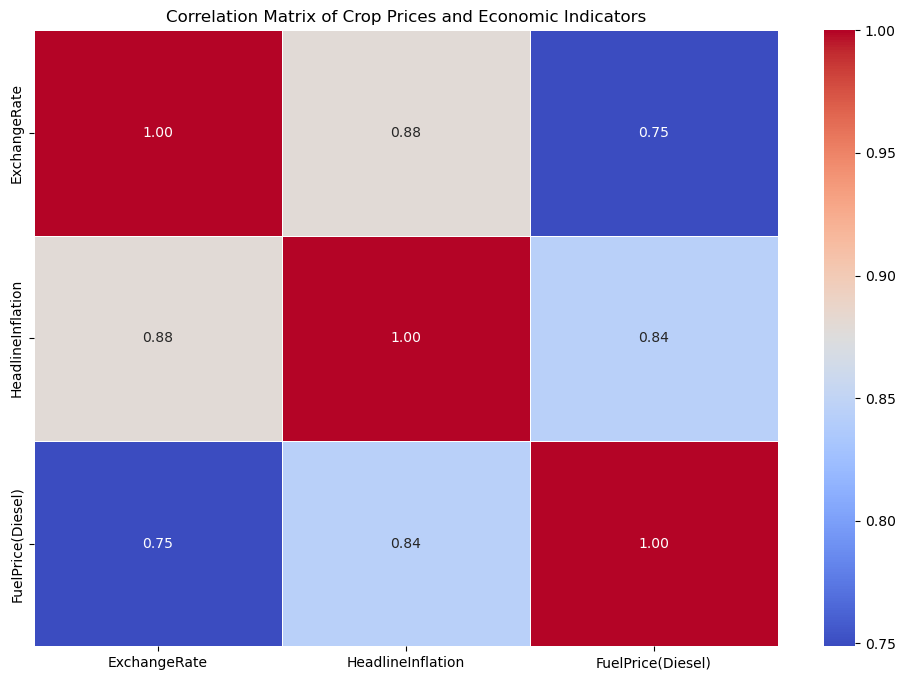

In [29]:
# Select numerical columns from the original DataFrame
df_selected_data = df[['ExchangeRate', 'HeadlineInflation', 'FuelPrice(Diesel)']]

# Calculate the correlation matrix on the selected columns
correlation_matrix = df_selected_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Crop Prices and Economic Indicators')
plt.show()


In [30]:
# Print the rounded correlation matrix
print("Correlation Matrix (Rounded):")
print(correlation_matrix.round(2))


Correlation Matrix (Rounded):
                   ExchangeRate  HeadlineInflation  FuelPrice(Diesel)
ExchangeRate               1.00               0.88               0.75
HeadlineInflation          0.88               1.00               0.84
FuelPrice(Diesel)          0.75               0.84               1.00


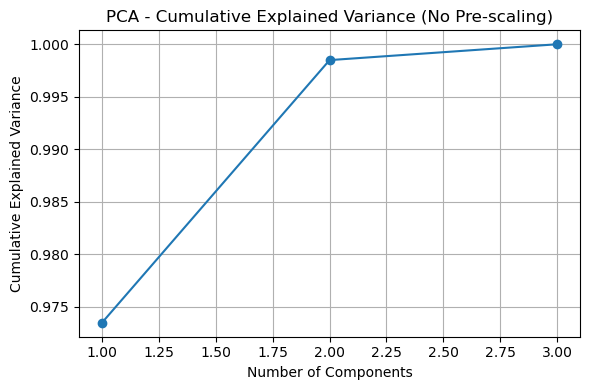

Explained Variance Ratio (each component):
PC1: 0.9735
PC2: 0.0250
PC3: 0.0015

PCA Loadings (Component Weights):
     ExchangeRate  HeadlineInflation  FuelPrice(Diesel)
PC1      0.184140           0.089965           0.978774
PC2      0.949462           0.241249          -0.200800
PC3     -0.254193           0.966284          -0.040995


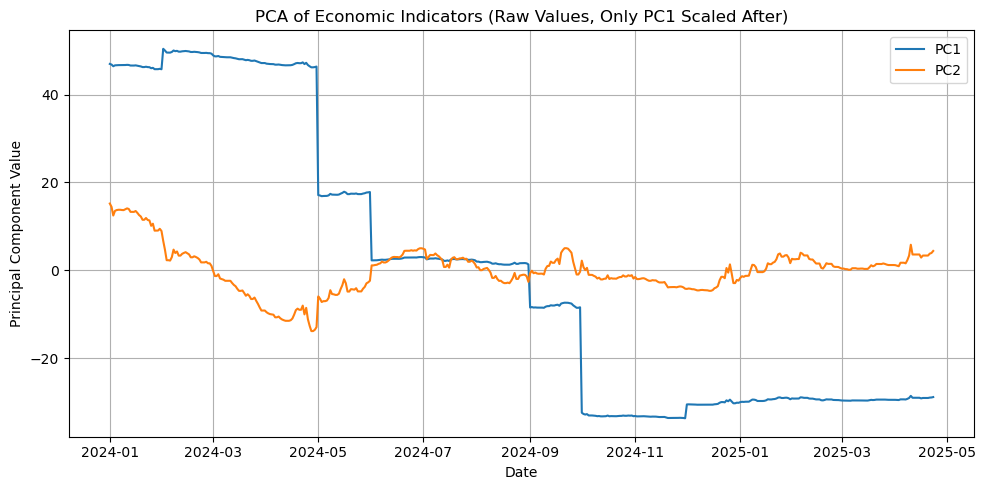

            ExchangeRate  HeadlineInflation  FuelPrice(Diesel)  EconIndex
Date                                                                     
2024-01-01      323.9902              200.7              358.0   0.959088
2024-01-02      323.1861              200.7              358.0   0.957325
2024-01-03      321.1200              200.7              358.0   0.952797
2024-01-04      322.2375              200.7              358.0   0.955246
2024-01-05      322.4275              200.7              358.0   0.955663


In [31]:
# Select features for PCA
features = ['ExchangeRate', 'HeadlineInflation', 'FuelPrice(Diesel)']
X = df[features]

# Apply PCA without pre-scaling
pca = PCA()
X_pca = pca.fit_transform(X)

# Explained variance
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

# Plot cumulative explained variance
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(cumulative_var)+1), cumulative_var, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Cumulative Explained Variance (No Pre-scaling)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print explained variance ratios
print("Explained Variance Ratio (each component):")
for i, var in enumerate(explained_var, 1):
    print(f"PC{i}: {var:.4f}")

# Print PCA loadings (component weights)
loadings = pd.DataFrame(pca.components_, columns=features,
                        index=[f'PC{i+1}' for i in range(len(features))])
print("\nPCA Loadings (Component Weights):")
print(loadings)

# Extract PC1 and scale it to range 0–1 as "Econ Index"
pc1 = X_pca[:, 0].reshape(-1, 1)
econ_index_scaled = MinMaxScaler().fit_transform(pc1)
econ_index_df = pd.DataFrame(econ_index_scaled, columns=['EconIndex'], index=df.index)

# Add Econ Index to main DataFrame
df['EconIndex'] = econ_index_df['EconIndex']

# Plot PC1 and PC2 over time
pca_df = pd.DataFrame(X_pca[:, :2], columns=['PC1', 'PC2'], index=df.index)

plt.figure(figsize=(10, 5))
plt.plot(pca_df.index, pca_df['PC1'], label='PC1')
plt.plot(pca_df.index, pca_df['PC2'], label='PC2')
plt.xlabel('Date')
plt.ylabel('Principal Component Value')
plt.title('PCA of Economic Indicators (Raw Values, Only PC1 Scaled After)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: View the updated DataFrame with Econ Index
print(df[['ExchangeRate', 'HeadlineInflation', 'FuelPrice(Diesel)', 'EconIndex']].head())

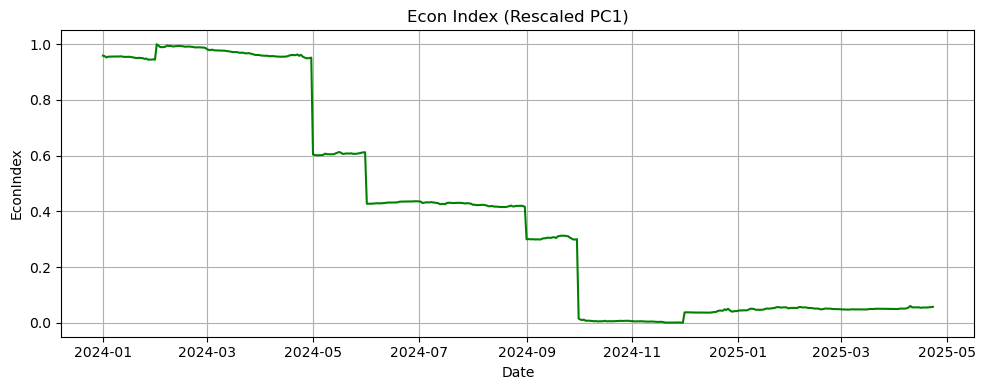

In [32]:

# Optional: Plot the Econ Index over time
plt.figure(figsize=(10, 4))
plt.plot(econ_index_df.index, econ_index_df['EconIndex'], color='green')
plt.title('Econ Index (Rescaled PC1)')
plt.xlabel('Date')
plt.ylabel('EconIndex')
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:

# Print the updated DataFrame (first few rows)
print(df.head())


            ExchangeRate  HeadlineInflation  FuelPrice(Diesel)  Beans  Carrot  \
Date                                                                            
2024-01-01      323.9902              200.7              358.0  450.0   550.0   
2024-01-02      323.1861              200.7              358.0  550.0   700.0   
2024-01-03      321.1200              200.7              358.0  500.0   700.0   
2024-01-04      322.2375              200.7              358.0  450.0   750.0   
2024-01-05      322.4275              200.7              358.0  450.0   700.0   

            Cabbage  Tomato  Brinjal  Pumpkin  Snake gourd  Green Chilli  \
Date                                                                       
2024-01-01    450.0   400.0    700.0    150.0        200.0        1250.0   
2024-01-02    500.0   600.0    450.0    150.0        200.0        1300.0   
2024-01-03    450.0   600.0    550.0    150.0        200.0        1300.0   
2024-01-04    400.0   550.0    600.0    150.0       

In [34]:
# Save the updated DataFrame to a CSV file
df.to_csv("dataset_with_econindex.csv", index=True)

# Print confirmation message
print("Dataset saved as 'dataset_with_econindex.csv'")


Dataset saved as 'dataset_with_econindex.csv'


In [35]:
df = df.drop(columns=['ExchangeRate', 'HeadlineInflation', 'FuelPrice(Diesel)'])
print(df.head())


            Beans  Carrot  Cabbage  Tomato  Brinjal  Pumpkin  Snake gourd  \
Date                                                                        
2024-01-01  450.0   550.0    450.0   400.0    700.0    150.0        200.0   
2024-01-02  550.0   700.0    500.0   600.0    450.0    150.0        200.0   
2024-01-03  500.0   700.0    450.0   600.0    550.0    150.0        200.0   
2024-01-04  450.0   750.0    400.0   550.0    600.0    150.0        180.0   
2024-01-05  450.0   700.0    430.0   550.0    550.0    150.0        180.0   

            Green Chilli  Red Onion (Local)  Potato (Local)  Red Dhal  \
Date                                                                    
2024-01-01        1250.0              350.0           353.0     300.0   
2024-01-02        1300.0              500.0           360.0     300.0   
2024-01-03        1300.0              500.0           363.0     300.0   
2024-01-04        1100.0              500.0           358.0     300.0   
2024-01-05        1000

In [36]:
# Select columns for correlation (PC1 and all vegetable price columns)
vegetable_columns = ['Beans', 'Carrot', 'Cabbage', 'Tomato', 'Brinjal', 'Pumpkin', 
                     'Snake gourd', 'Green Chilli', 'Red Onion (Local)', 'Potato (Local)', 'Red Dhal', 'Banana (Sour)', 'Papaw']

# Calculate the correlation between PC1 and each vegetable price
correlation_with_pc1 = df[vegetable_columns].corrwith(df['EconIndex'])

# Print the correlation results
print("Correlation between EconIndex and Vegetable Prices:")
print(correlation_with_pc1)


Correlation between EconIndex and Vegetable Prices:
Beans                0.009484
Carrot               0.341509
Cabbage              0.519799
Tomato               0.276469
Brinjal             -0.038138
Pumpkin              0.422755
Snake gourd         -0.112009
Green Chilli        -0.174480
Red Onion (Local)    0.284078
Potato (Local)       0.025362
Red Dhal             0.821024
Banana (Sour)        0.600142
Papaw                0.251539
dtype: float64


### Time Series

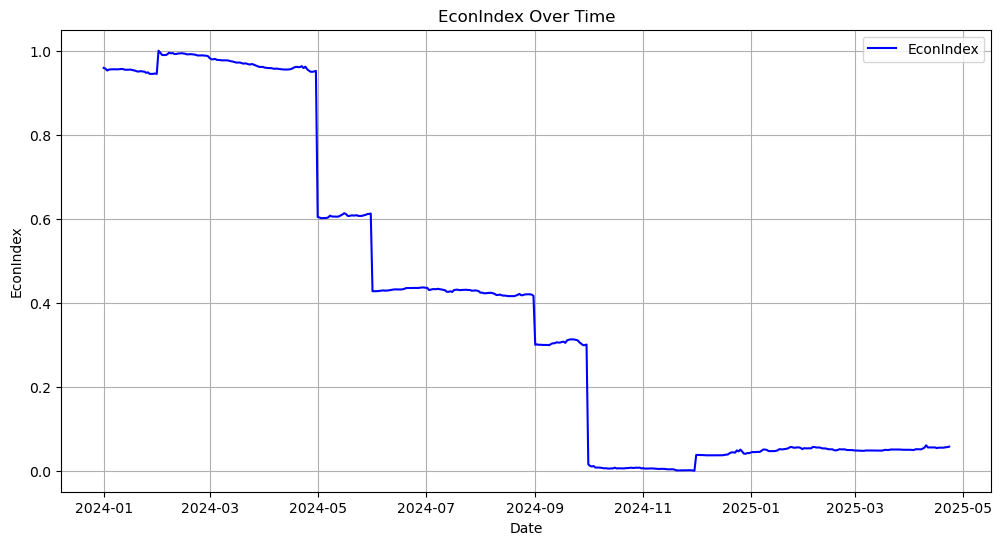

In [37]:
# Visualizing EconIndex over time
plt.figure(figsize=(12, 6))
plt.plot(df['EconIndex'], label='EconIndex', color='blue')
plt.title('EconIndex Over Time')
plt.xlabel('Date')
plt.ylabel('EconIndex')
plt.legend()
plt.grid(True)
plt.show()

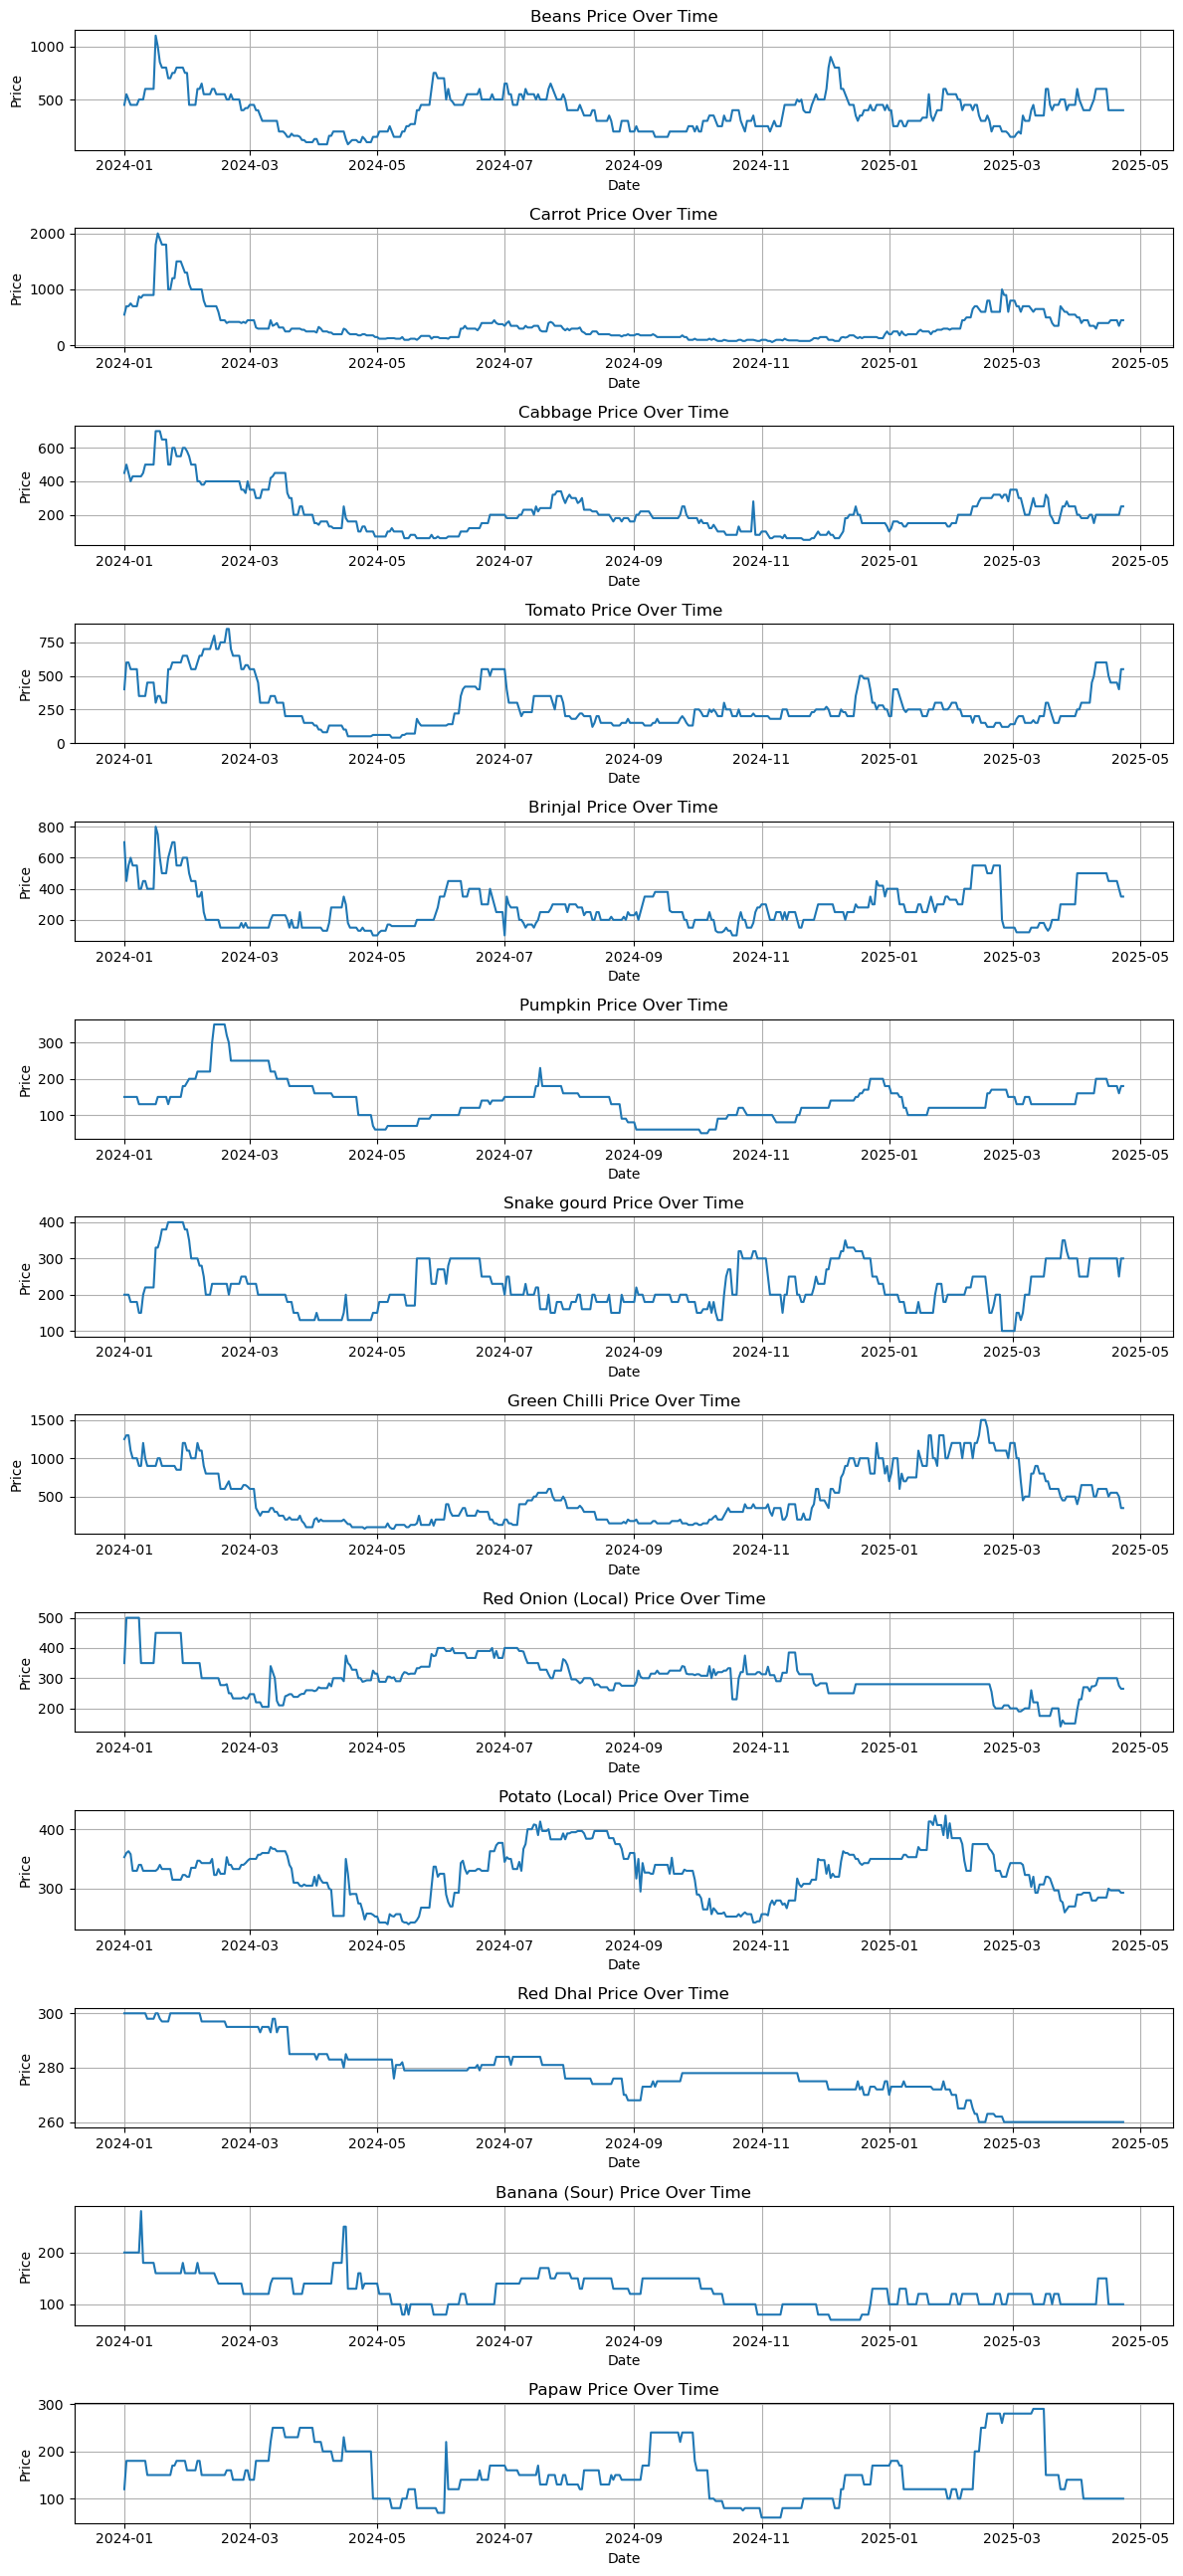

In [38]:
# Visualizing each vegetable price separately using subplots
fig, axes = plt.subplots(len(vegetable_columns), 1, figsize=(12, 2 * len(vegetable_columns)))

# Loop through each vegetable and create a subplot for it
for i, vegetable in enumerate(vegetable_columns):
    axes[i].plot(df.index, df[vegetable], label=vegetable)
    axes[i].set_title(f'{vegetable} Price Over Time')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Price')
    axes[i].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

In [39]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

# Variables to test (excluding EconIndex in final DataFrames)
columns_to_test = ['EconIndex', 'Beans', 'Carrot', 'Cabbage', 'Tomato', 'Brinjal',
                   'Pumpkin', 'Snake gourd', 'Green Chilli', 'Red Onion (Local)',
                   'Potato (Local)', 'Red Dhal', 'Banana (Sour)', 'Papaw']

integration_order = {}  # To store I(0), I(1), etc.

def get_adf_result(series, signif=0.05, max_diff=2):
    level = 0
    current_series = series.copy()
    while level <= max_diff:
        # result = adfuller(current_series.dropna(), autolag='AIC')
        result = adfuller(current_series.dropna(), autolag='AIC', regression='ct')
        p_value = result[1]
        if p_value < signif:
            return level  # Stationary at current level (I(level))
        else:
            current_series = current_series.diff()
            level += 1
    return None  # Not stationary even at I(2)

# Run ADF tests and determine integration order
for col in columns_to_test:
    order = get_adf_result(df[col])
    integration_order[col] = order
    status = f"I({order})" if order is not None else "Non-stationary even at I(2)"
    print(f"{col}: {status}")

print("\n" + "="*60)

# Separate into I(0) and I(1) DataFrames, excluding EconIndex
i0_columns = [col for col, order in integration_order.items() if order == 0 and col != 'EconIndex']
i1_columns = [col for col, order in integration_order.items() if order == 1 and col != 'EconIndex']

df_i0 = df[i0_columns].copy()
df_i1 = df[i1_columns].copy()
econ_index = df[['EconIndex']].copy()

# Final results
print(f"I(0) Variables: {i0_columns}")
print(f"I(1) Variables: {i1_columns}")


EconIndex: I(1)
Beans: I(1)
Carrot: I(0)
Cabbage: I(1)
Tomato: I(1)
Brinjal: I(0)
Pumpkin: I(1)
Snake gourd: I(0)
Green Chilli: I(1)
Red Onion (Local): I(0)
Potato (Local): I(1)
Red Dhal: I(1)
Banana (Sour): I(0)
Papaw: I(1)

I(0) Variables: ['Carrot', 'Brinjal', 'Snake gourd', 'Red Onion (Local)', 'Banana (Sour)']
I(1) Variables: ['Beans', 'Cabbage', 'Tomato', 'Pumpkin', 'Green Chilli', 'Potato (Local)', 'Red Dhal', 'Papaw']


<Figure size 1000x600 with 0 Axes>

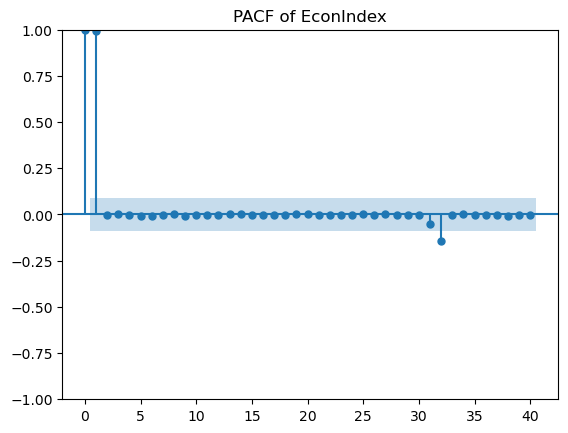

<Figure size 1000x600 with 0 Axes>

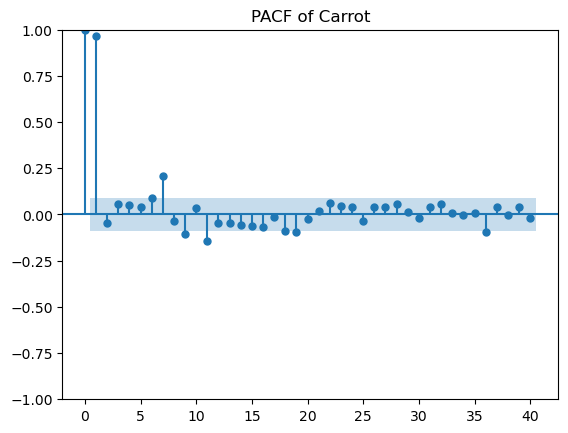

<Figure size 1000x600 with 0 Axes>

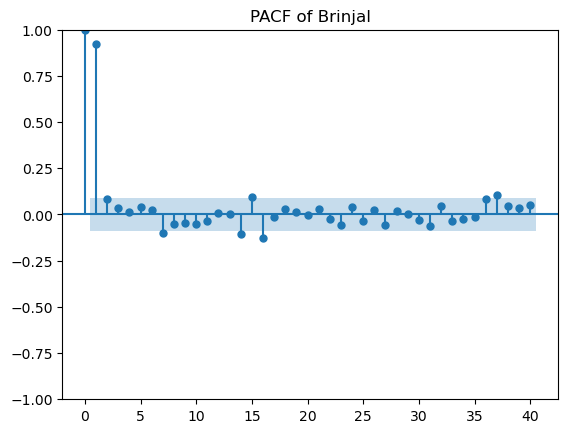

<Figure size 1000x600 with 0 Axes>

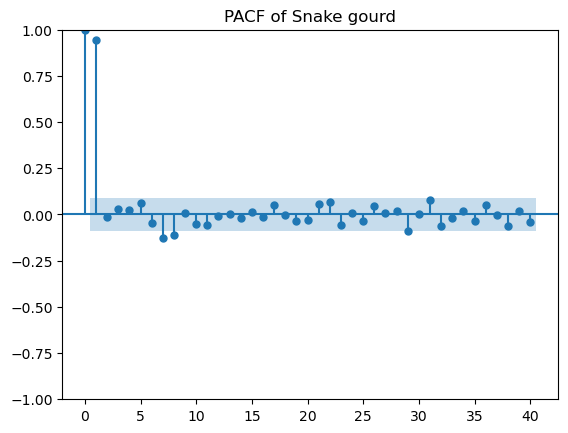

<Figure size 1000x600 with 0 Axes>

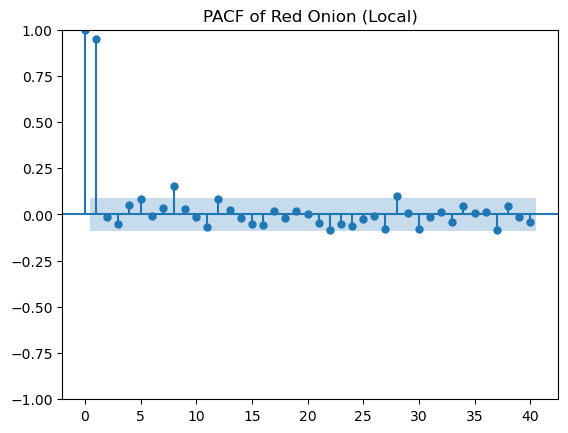

<Figure size 1000x600 with 0 Axes>

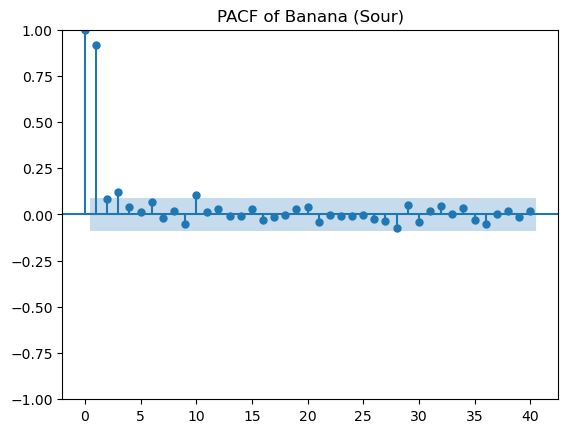

In [40]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

# Filter only I(0) variables, excluding 'EconIndex'
i0_columns = [col for col, order in integration_order.items() if order == 0 and col != 'EconIndex']

plt.figure(figsize=(10, 6))
plot_pacf(df['EconIndex'], lags=40, method='ywm', title="PACF of EconIndex")
plt.show()

# Loop through each I(0) variable and plot PACF
for var in i0_columns:
    df_var = df[var]
    
    plt.figure(figsize=(10, 6))
    plot_pacf(df_var, lags=40, method='ywm', title=f"PACF of {var}")
    plt.show()



In [41]:
from statsmodels.tsa.stattools import pacf
import numpy as np

# Assuming you have the list of I(0) variables, as before
i0_columns = [col for col, order in integration_order.items() if order == 0]  # Get only I(0) variables

# Loop through each I(0) variable (excluding 'EconIndex') and calculate PACF values
for var in i0_columns:
    # Get the dataset for the current I(0) variable
    df_var = df[var]
    
    # Calculate PACF for the variable (up to 40 lags, adjust if needed)
    pacf_values = pacf(df_var, nlags=40)
    
    # Identify the significant lags based on PACF values (values greater than 0.2 or less than -0.2)
    significant_lags = np.where(np.abs(pacf_values) > 0.2)[0]  # Threshold for significance

    # Display results for the PACF values and significant lags
    print(f"PACF for {var}:")
    print(f"  PACF values: {pacf_values}")
    print(f"  Significant lags (abs(pacf) > 0.2): {significant_lags}")
    print(f"  Number of significant lags: {len(significant_lags)}")
    print("-" * 40)

# For 'EconIndex', calculate PACF separately
df_econ = df['EconIndex']
pacf_values_econ = pacf(df_econ, nlags=40)
significant_lags_econ = np.where(np.abs(pacf_values_econ) > 0.2)[0]

# Display PACF for EconIndex separately
print(f"PACF for EconIndex:")
print(f"  PACF values: {pacf_values_econ}")
print(f"  Significant lags (abs(pacf) > 0.2): {significant_lags_econ}")
print(f"  Number of significant lags: {len(significant_lags_econ)}")
print("-" * 40)


PACF for Carrot:
  PACF values: [ 1.00000000e+00  9.70219761e-01 -5.07386975e-02  6.11662745e-02
  5.55446698e-02  4.24398423e-02  9.87621493e-02  2.26329031e-01
 -3.49336270e-02 -1.15182288e-01  4.07972146e-02 -1.57995425e-01
 -5.01085431e-02 -4.67686154e-02 -6.75447574e-02 -7.62020179e-02
 -7.49395958e-02 -2.44847055e-02 -1.06395911e-01 -1.11433341e-01
 -3.36924380e-02  1.39779952e-02  6.68875904e-02  5.62015848e-02
  5.03280938e-02 -3.87038165e-02  5.89256389e-02  5.38845671e-02
  7.49768435e-02  2.55159276e-02 -1.39032400e-02  5.45571105e-02
  7.50061966e-02  1.84293215e-02  1.50471882e-04  7.12963223e-03
 -1.15811005e-01  4.15676654e-02 -1.26176470e-02  3.94508518e-02
 -3.08018275e-02]
  Significant lags (abs(pacf) > 0.2): [0 1 7]
  Number of significant lags: 3
----------------------------------------
PACF for Brinjal:
  PACF values: [ 1.00000000e+00  9.26805640e-01  8.79337798e-02  3.45633286e-02
  1.49598667e-02  4.08956421e-02  2.42916727e-02 -1.04142349e-01
 -5.65888477e-02 -

In [42]:
# List of vegetables to create datasets for


# Loop through each vegetable and create a separate dataset
for vegetable in i0_columns:
    df_vegetable = df[['EconIndex', vegetable]]
    globals()[f"df_{vegetable.lower()}"] = df_vegetable  # Create a variable with the vegetable name

    # Optional: Check the first few rows of the newly created dataset
    print(f"\ndf_{vegetable.lower()} created:")
    print(globals()[f"df_{vegetable.lower()}"].head())



df_carrot created:
            EconIndex  Carrot
Date                         
2024-01-01   0.959088   550.0
2024-01-02   0.957325   700.0
2024-01-03   0.952797   700.0
2024-01-04   0.955246   750.0
2024-01-05   0.955663   700.0

df_brinjal created:
            EconIndex  Brinjal
Date                          
2024-01-01   0.959088    700.0
2024-01-02   0.957325    450.0
2024-01-03   0.952797    550.0
2024-01-04   0.955246    600.0
2024-01-05   0.955663    550.0

df_snake gourd created:
            EconIndex  Snake gourd
Date                              
2024-01-01   0.959088        200.0
2024-01-02   0.957325        200.0
2024-01-03   0.952797        200.0
2024-01-04   0.955246        180.0
2024-01-05   0.955663        180.0

df_red onion (local) created:
            EconIndex  Red Onion (Local)
Date                                    
2024-01-01   0.959088              350.0
2024-01-02   0.957325              500.0
2024-01-03   0.952797              500.0
2024-01-04   0.955246     

In [43]:
df.head()

,Beans,Carrot,Cabbage,Tomato,Brinjal,Pumpkin,Snake gourd,Green Chilli,Red Onion (Local),Potato (Local),Red Dhal,Banana (Sour),Papaw,EconIndex
Date,,,,,,,,,,,,,,
2024-01-01,450.0,550.0,450.0,400.0,700.0,150.0,200.0,1250.0,350.0,353.0,300.0,200.0,120.0,0.959088
2024-01-02,550.0,700.0,500.0,600.0,450.0,150.0,200.0,1300.0,500.0,360.0,300.0,200.0,180.0,0.957325
2024-01-03,500.0,700.0,450.0,600.0,550.0,150.0,200.0,1300.0,500.0,363.0,300.0,200.0,180.0,0.952797
2024-01-04,450.0,750.0,400.0,550.0,600.0,150.0,180.0,1100.0,500.0,358.0,300.0,200.0,180.0,0.955246
2024-01-05,450.0,700.0,430.0,550.0,550.0,150.0,180.0,1000.0,500.0,330.0,300.0,200.0,180.0,0.955663


### ARDL

Processing Carrot...
ADF Test for Carrot:
Test Statistic: -6.838821176698599
P-Value: 1.8132382203504239e-09
Carrot is stationary.

ADF Test for EconIndex:
Test Statistic: -1.1816775604750187
P-Value: 0.6814274877205453
EconIndex is NOT stationary. Differencing may be needed.

Best ARDL model for Carrot uses 10 lags (based on AIC).

                              ARDL Model Results                              
Dep. Variable:                 Carrot   No. Observations:                  479
Model:                   ARDL(10, 10)   Log Likelihood               -2677.622
Method:               Conditional MLE   S.D. of innovations             72.987
Date:                Wed, 23 Apr 2025   AIC                           5383.243
Time:                        14:29:07   BIC                           5441.352
Sample:                    01-11-2024   HQIC                          5406.107
                         - 04-23-2025                                         
                    coef    std e

C:\Users\nipunisi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nipunisi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nipunisi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nipunisi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nipunisi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

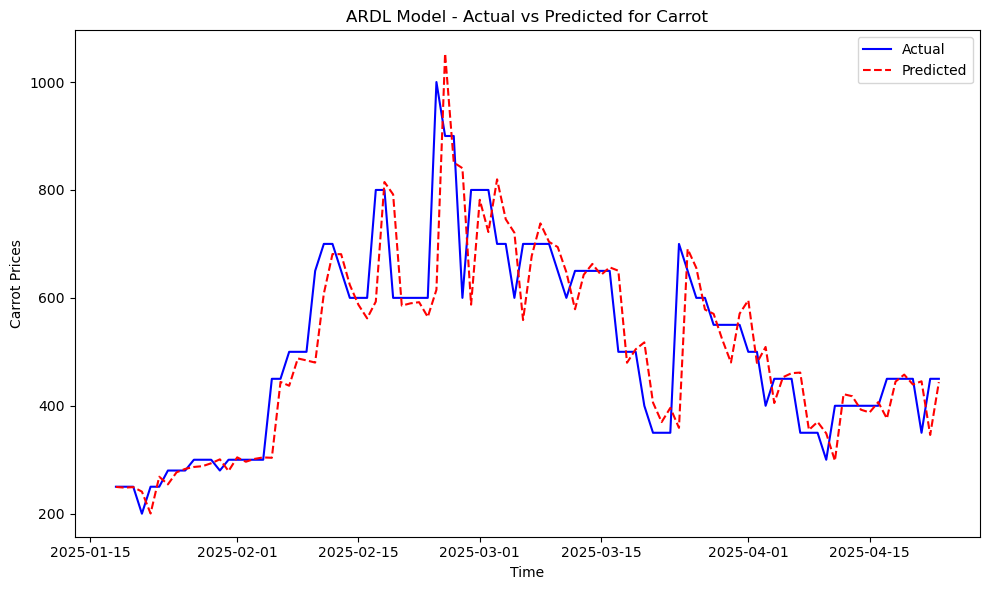

Processing Brinjal...
ADF Test for Brinjal:
Test Statistic: -3.7954953500738955
P-Value: 0.0029537411754239516
Brinjal is stationary.

ADF Test for EconIndex:
Test Statistic: -1.1816775604750187
P-Value: 0.6814274877205453
EconIndex is NOT stationary. Differencing may be needed.

Best ARDL model for Brinjal uses 10 lags (based on AIC).

                              ARDL Model Results                              
Dep. Variable:                Brinjal   No. Observations:                  479
Model:                   ARDL(10, 10)   Log Likelihood               -2434.198
Method:               Conditional MLE   S.D. of innovations             43.434
Date:                Wed, 23 Apr 2025   AIC                           4896.395
Time:                        14:29:07   BIC                           4954.504
Sample:                    01-11-2024   HQIC                          4919.259
                         - 04-23-2025                                         
                    coef    s

C:\Users\nipunisi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nipunisi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nipunisi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nipunisi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nipunisi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

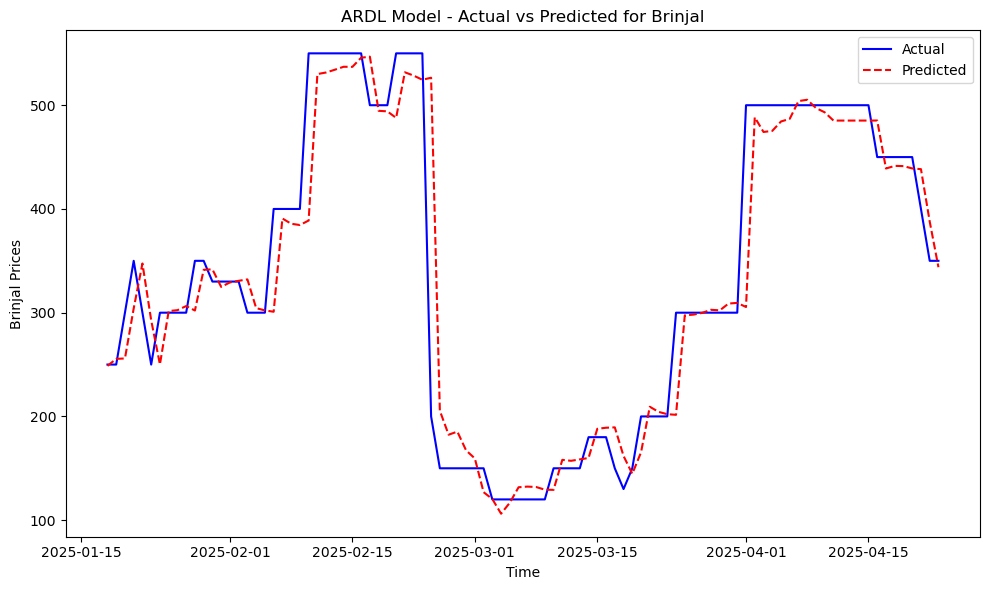

Processing Snake gourd...
ADF Test for Snake gourd:
Test Statistic: -3.8733168903358073
P-Value: 0.002240236052051543
Snake gourd is stationary.

ADF Test for EconIndex:
Test Statistic: -1.1816775604750187
P-Value: 0.6814274877205453
EconIndex is NOT stationary. Differencing may be needed.

Best ARDL model for Snake gourd uses 10 lags (based on AIC).

                              ARDL Model Results                              
Dep. Variable:            Snake gourd   No. Observations:                  479
Model:                   ARDL(10, 10)   Log Likelihood               -2082.529
Method:               Conditional MLE   S.D. of innovations             20.520
Date:                Wed, 23 Apr 2025   AIC                           4193.057
Time:                        14:29:07   BIC                           4251.166
Sample:                    01-11-2024   HQIC                          4215.921
                         - 04-23-2025                                         
              

C:\Users\nipunisi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nipunisi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nipunisi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nipunisi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nipunisi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

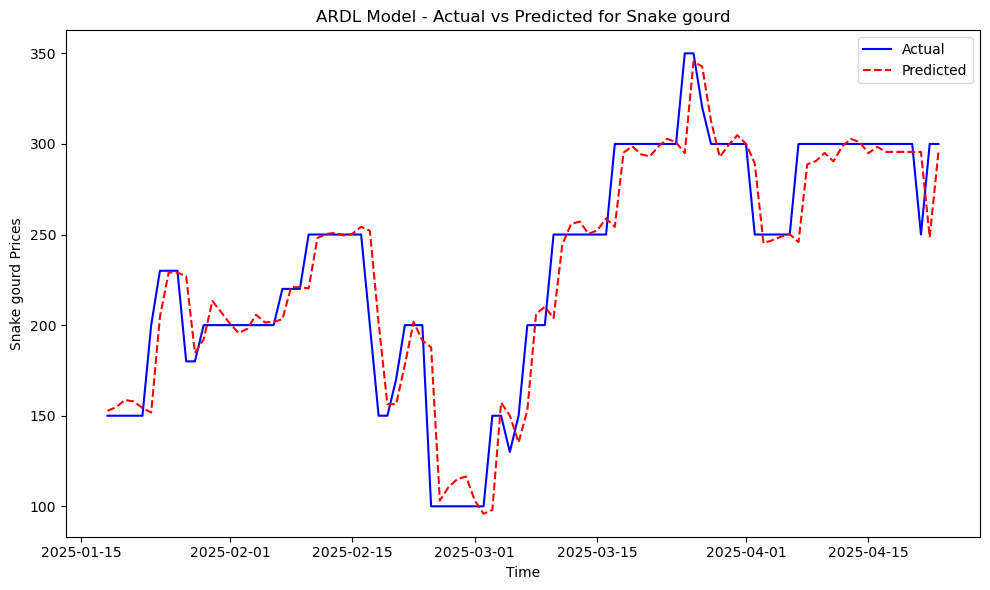

Processing Red Onion (Local)...
ADF Test for Red Onion (Local):
Test Statistic: -3.633088537355171
P-Value: 0.005159058600651754
Red Onion (Local) is stationary.

ADF Test for EconIndex:
Test Statistic: -1.1816775604750187
P-Value: 0.6814274877205453
EconIndex is NOT stationary. Differencing may be needed.

Best ARDL model for Red Onion (Local) uses 10 lags (based on AIC).

                              ARDL Model Results                              
Dep. Variable:      Red Onion (Local)   No. Observations:                  479
Model:                   ARDL(10, 10)   Log Likelihood               -1995.323
Method:               Conditional MLE   S.D. of innovations             17.039
Date:                Wed, 23 Apr 2025   AIC                           4018.646
Time:                        14:29:08   BIC                           4076.755
Sample:                    01-11-2024   HQIC                          4041.510
                         - 04-23-2025                                 

C:\Users\nipunisi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nipunisi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nipunisi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nipunisi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nipunisi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

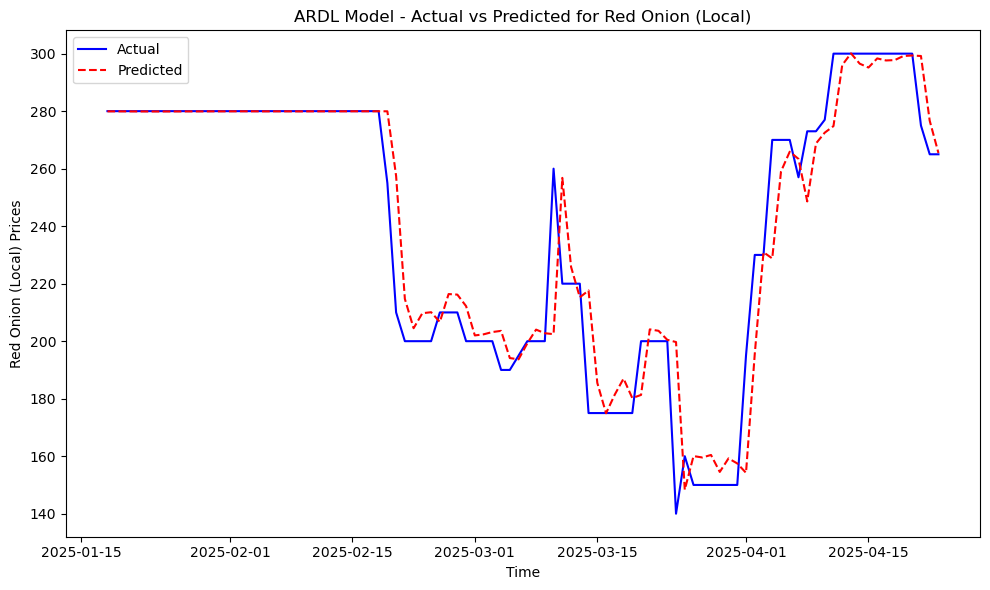

Processing Banana (Sour)...
ADF Test for Banana (Sour):
Test Statistic: -3.7883671375745473
P-Value: 0.003028602186221271
Banana (Sour) is stationary.

ADF Test for EconIndex:
Test Statistic: -1.1816775604750187
P-Value: 0.6814274877205453
EconIndex is NOT stationary. Differencing may be needed.

Best ARDL model for Banana (Sour) uses 10 lags (based on AIC).

                              ARDL Model Results                              
Dep. Variable:          Banana (Sour)   No. Observations:                  479
Model:                   ARDL(10, 10)   Log Likelihood               -1753.817
Method:               Conditional MLE   S.D. of innovations             10.181
Date:                Wed, 23 Apr 2025   AIC                           3535.634
Time:                        14:29:08   BIC                           3593.742
Sample:                    01-11-2024   HQIC                          3558.497
                         - 04-23-2025                                         
      

C:\Users\nipunisi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nipunisi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nipunisi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nipunisi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nipunisi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

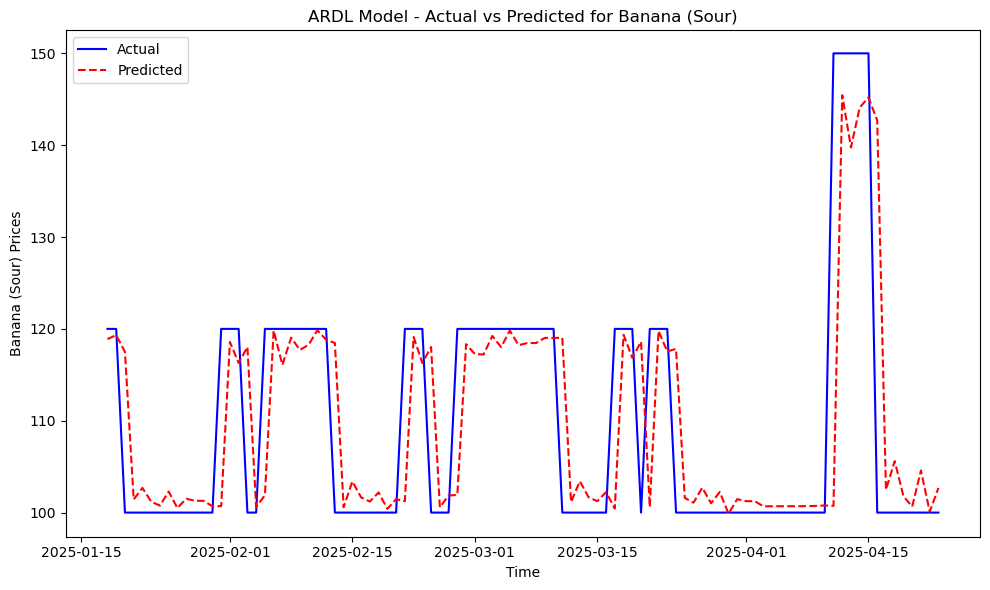

           Vegetable  R² Score       RMSE
0             Carrot  0.745733  88.192516
1            Brinjal  0.887056  49.320328
2        Snake gourd  0.887766  21.701871
3  Red Onion (Local)  0.902347  15.132270
4      Banana (Sour)  0.463453   9.773438
✅ CSV exported: 'predicted_ardl.csv'


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ardl import ARDL
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# Function to check stationarity
def check_stationarity(series, name):
    result = adfuller(series)
    print(f"ADF Test for {name}:")
    print(f"Test Statistic: {result[0]}")
    print(f"P-Value: {result[1]}")
    if result[1] <= 0.05:
        print(f"{name} is stationary.\n")
    else:
        print(f"{name} is NOT stationary. Differencing may be needed.\n")

# Initialize results storage
df_results = []
all_forecasts = []  # To store predictions vs actuals

# Loop through each vegetable in `i0_columns`
for veg in i0_columns:
    print(f"Processing {veg}...")

    # Get dataset for the specific vegetable (df_veg)
    df_veg = globals().get(f"df_{veg.lower()}")  # Get dataset
    if df_veg is None:
        print(f"Dataset for {veg} not found! Skipping.\n")
        continue

    # Drop NA just in case
    df_veg = df_veg.dropna()

    # Check stationarity for vegetable and EconIndex
    check_stationarity(df_veg[veg], veg)
    check_stationarity(df_veg['EconIndex'], 'EconIndex')

    # Determine optimal lag using AIC
    max_lag = 10
    best_aic = float('inf')
    best_lag = None

    for lag in range(1, max_lag + 1):
        try:
            model = ARDL(df_veg[veg], lags=lag, exog=df_veg[['EconIndex']], order=(lag, 0))
            result = model.fit()
            if result.aic < best_aic:
                best_aic = result.aic
                best_lag = lag
        except:
            continue

    print(f"Best ARDL model for {veg} uses {best_lag} lags (based on AIC).\n")

    # Fit the final ARDL model
    model = ARDL(df_veg[veg], lags=best_lag, exog=df_veg[['EconIndex']], order=(best_lag, 0))
    result = model.fit()
    print(result.summary())

    # Train-test split
    train_size = int(len(df_veg) * 0.8)
    train, test = df_veg.iloc[:train_size], df_veg.iloc[train_size:]

    # Forecasting
    preds = result.predict(start=train_size, end=len(df_veg) - 1, exog_oos=test[['EconIndex']])

    # Evaluation
    rmse = sqrt(mean_squared_error(test[veg], preds))
    r2 = r2_score(test[veg], preds)
    print(f"ARDL - RMSE for {veg}: {rmse}")
    print(f"ARDL - R² for {veg}: {r2}\n")

    # Store performance
    df_results.append({
        'Vegetable': veg,
        'R² Score': r2,
        'RMSE': rmse
    })

    # Store forecasted results for CSV
    df_forecast = pd.DataFrame({
        'Date': test.index,
        'Vegetable': veg,
        'Actual': test[veg].values,
        'Predicted': preds.values
    })
    all_forecasts.append(df_forecast)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(test.index, test[veg], label="Actual", color="blue")
    plt.plot(test.index, preds, label="Predicted", color="red", linestyle="dashed")
    plt.xlabel("Time")
    plt.ylabel(f"{veg} Prices")
    plt.title(f"ARDL Model - Actual vs Predicted for {veg}")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Results summary
df_metrics = pd.DataFrame(df_results)
print(df_metrics)

# Save predictions to CSV
df_all_forecasts = pd.concat(all_forecasts)
df_all_forecasts.to_csv("predicted_ardl.csv", index=False)
print("✅ CSV exported: 'predicted_ardl.csv'")


In [45]:
df.head()


,Beans,Carrot,Cabbage,Tomato,Brinjal,Pumpkin,Snake gourd,Green Chilli,Red Onion (Local),Potato (Local),Red Dhal,Banana (Sour),Papaw,EconIndex
Date,,,,,,,,,,,,,,
2024-01-01,450.0,550.0,450.0,400.0,700.0,150.0,200.0,1250.0,350.0,353.0,300.0,200.0,120.0,0.959088
2024-01-02,550.0,700.0,500.0,600.0,450.0,150.0,200.0,1300.0,500.0,360.0,300.0,200.0,180.0,0.957325
2024-01-03,500.0,700.0,450.0,600.0,550.0,150.0,200.0,1300.0,500.0,363.0,300.0,200.0,180.0,0.952797
2024-01-04,450.0,750.0,400.0,550.0,600.0,150.0,180.0,1100.0,500.0,358.0,300.0,200.0,180.0,0.955246
2024-01-05,450.0,700.0,430.0,550.0,550.0,150.0,180.0,1000.0,500.0,330.0,300.0,200.0,180.0,0.955663


### VECM

In [46]:
i1_columns


['Beans',
 'Cabbage',
 'Tomato',
 'Pumpkin',
 'Green Chilli',
 'Potato (Local)',
 'Red Dhal',
 'Papaw']

In [47]:
for vegetable in i1_columns:
    clean_name = vegetable.lower().replace(" ", "_")
    df_vegetable = df[['EconIndex', vegetable]]
    globals()[f"df_{clean_name}"] = df_vegetable
    print(f"\ndf_{clean_name} created:")
    print(df_vegetable.head())



df_beans created:
            EconIndex  Beans
Date                        
2024-01-01   0.959088  450.0
2024-01-02   0.957325  550.0
2024-01-03   0.952797  500.0
2024-01-04   0.955246  450.0
2024-01-05   0.955663  450.0

df_cabbage created:
            EconIndex  Cabbage
Date                          
2024-01-01   0.959088    450.0
2024-01-02   0.957325    500.0
2024-01-03   0.952797    450.0
2024-01-04   0.955246    400.0
2024-01-05   0.955663    430.0

df_tomato created:
            EconIndex  Tomato
Date                         
2024-01-01   0.959088   400.0
2024-01-02   0.957325   600.0
2024-01-03   0.952797   600.0
2024-01-04   0.955246   550.0
2024-01-05   0.955663   550.0

df_pumpkin created:
            EconIndex  Pumpkin
Date                          
2024-01-01   0.959088    150.0
2024-01-02   0.957325    150.0
2024-01-03   0.952797    150.0
2024-01-04   0.955246    150.0
2024-01-05   0.955663    150.0

df_green_chilli created:
            EconIndex  Green Chilli
Date      

In [48]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# List to collect evaluation results
evaluation_results = []

def check_cointegration_fit_and_evaluate(df_vegetable, vegetable_name, forecast_steps=5):
    print(f"\n🔍 Checking: {vegetable_name}")
    df_vegetable = df_vegetable.dropna()

    try:
        # Step 1: Johansen Cointegration Test
        result = coint_johansen(df_vegetable, det_order=0, k_ar_diff=1)
        trace_stat = result.lr1
        critical_values = result.cvt[:, 1]  # 5% level

        cointegrated = any(trace_stat > critical_values)
        print(f"Cointegration result: {'✅ Cointegrated' if cointegrated else '❌ Not cointegrated'}")

        # Step 2: Fit model
        if cointegrated:
            model = VECM(df_vegetable, k_ar_diff=1, coint_rank=1, deterministic="co").fit()
            forecast = model.predict(steps=forecast_steps)
            actual = df_vegetable.values[-forecast_steps:]
            print(f"✅ VECM model fitted for {vegetable_name}")
            print(model.summary())
            model_type = "VECM"
        else:
            df_diff = df_vegetable.diff().dropna()
            var_model = VAR(df_diff)
            var_result = var_model.fit(maxlags=15, ic='aic')
            forecast_input = df_diff.values[-var_result.k_ar:]
            forecast = var_result.forecast(y=forecast_input, steps=forecast_steps)
            last_obs = df_vegetable.iloc[-var_result.k_ar].values
            forecast = np.vstack([
                last_obs + forecast[0],
                *[forecast[i] + forecast[i-1] for i in range(1, forecast_steps)]
            ])
            actual = df_vegetable.values[-forecast_steps:]
            print(f"✅ VAR model fitted for {vegetable_name}")
            print(var_result.summary())
            model_type = "VAR (Diff)"

        # Step 3: Evaluation
        actual_vals = actual[:, 1]
        predicted_vals = forecast[:, 1]
        rmse = np.sqrt(mean_squared_error(actual_vals, predicted_vals))
        r2 = r2_score(actual_vals, predicted_vals)

    except Exception as e:
        print(f"⚠️ Error processing {vegetable_name}: {e}")
        rmse = np.nan
        r2 = np.nan
        model_type = "Error"

    # Step 4: Save evaluation
    evaluation_results.append({
        "Vegetable": vegetable_name.capitalize(),
        "Model Used": model_type,
        "RMSE": round(rmse, 6),
        "R²": round(r2, 6)
    })

# --- Loop through all vegetables ---
for vegetable in i1_columns:
    clean_name = vegetable.lower().replace(" ", "_")
    df_veg = globals()[f"df_{clean_name}"]
    check_cointegration_fit_and_evaluate(df_veg, clean_name)

# --- Create final summary table ---
summary_df = pd.DataFrame(evaluation_results)
print("\n📊 Model Evaluation Summary:")
print(summary_df)



🔍 Checking: beans
Cointegration result: ✅ Cointegrated
✅ VECM model fitted for beans
Det. terms outside the coint. relation & lagged endog. parameters for equation EconIndex
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0051      0.003     -1.963      0.050      -0.010   -8.22e-06
L1.EconIndex    -0.0083      0.046     -0.181      0.857      -0.098       0.082
L1.Beans      5.046e-06   1.83e-05      0.276      0.783   -3.08e-05    4.09e-05
Det. terms outside the coint. relation & lagged endog. parameters for equation Beans
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           21.0426      6.456      3.259      0.001       8.389      33.696
L1.EconIndex    -1.7084    114.327     -0.015      0.988    -225.786     222.369
L1.Beans   

C:\Users\nipunisi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nipunisi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nipunisi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nipunisi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nipunisi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

✅ VAR model fitted for red_dhal
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 23, Apr, 2025
Time:                     14:29:10
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -7.13017
Nobs:                     477.000    HQIC:                  -7.16198
Log likelihood:           365.382    FPE:                0.000759694
AIC:                     -7.18260    Det(Omega_mle):     0.000750227
--------------------------------------------------------------------
Results for equation EconIndex
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const               -0.001902         0.001066           -1.783           0.075
L1.EconIndex        -0.005710         0.045932           -0.124           0.901
L1.Red Dhal         -0.00004

C:\Users\nipunisi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [49]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Lists to collect results
evaluation_results = []
combined_actual_predicted = []

def check_cointegration_fit_and_evaluate(df_vegetable, vegetable_name, forecast_steps=7):
    print(f"\n🔍 Checking: {vegetable_name}")
    df_vegetable = df_vegetable.dropna()

    try:
        # Step 1: Johansen Cointegration Test
        result = coint_johansen(df_vegetable, det_order=0, k_ar_diff=1)
        trace_stat = result.lr1
        critical_values = result.cvt[:, 1]  # 5% level

        cointegrated = any(trace_stat > critical_values)
        print(f"Cointegration result: {'✅ Cointegrated' if cointegrated else '❌ Not cointegrated'}")

        # Step 2: Fit model
        if cointegrated:
            model = VECM(df_vegetable, k_ar_diff=1, coint_rank=1, deterministic="co").fit()
            forecast = model.predict(steps=forecast_steps)
            actual = df_vegetable.values[-forecast_steps:]
            print(f"✅ VECM model fitted for {vegetable_name}")
            model_type = "VECM"
        else:
            df_diff = df_vegetable.diff().dropna()
            var_model = VAR(df_diff)
            var_result = var_model.fit(maxlags=15, ic='aic')
            forecast_input = df_diff.values[-var_result.k_ar:]
            forecast = var_result.forecast(y=forecast_input, steps=forecast_steps)

            # Re-integrate differenced forecast to original scale
            last_obs = df_vegetable.iloc[-var_result.k_ar].values
            forecast = np.vstack([
                last_obs + forecast[0],
                *[forecast[i] + forecast[i-1] for i in range(1, forecast_steps)]
            ])

            actual = df_vegetable.values[-forecast_steps:]
            print(f"✅ VAR model fitted for {vegetable_name}")
            model_type = "VAR (Diff)"

        # Step 3: Evaluation
        actual_vals = actual[:, 1]
        predicted_vals = forecast[:, 1]
        rmse = np.sqrt(mean_squared_error(actual_vals, predicted_vals))
        r2 = r2_score(actual_vals, predicted_vals)

        # Store actual vs predicted values (both models)
        for i in range(forecast_steps):
            combined_actual_predicted.append({
                "Vegetable": vegetable_name.capitalize(),
                "Index": i,
                "Actual": actual_vals[i],
                "Predicted": predicted_vals[i],
                "Model": model_type
            })

    except Exception as e:
        print(f"⚠️ Error processing {vegetable_name}: {e}")
        rmse = np.nan
        r2 = np.nan
        model_type = "Error"

    # Step 4: Save evaluation
    evaluation_results.append({
        "Vegetable": vegetable_name.capitalize(),
        "Model Used": model_type,
        "RMSE": round(rmse, 6),
        "R²": round(r2, 6)
    })

# --- Loop through all vegetables ---
for vegetable in i1_columns:
    clean_name = vegetable.lower().replace(" ", "_")
    df_veg = globals()[f"df_{clean_name}"]
    check_cointegration_fit_and_evaluate(df_veg, clean_name, forecast_steps=5)

# --- Summary Table ---
summary_df = pd.DataFrame(evaluation_results)
print("\n📊 Model Evaluation Summary:")
print(summary_df)

# --- Save combined Actual vs Predicted to CSV ---
combined_df = pd.DataFrame(combined_actual_predicted)
output_file = "predicted_vecm_var_short.csv"
combined_df.to_csv(output_file, index=False)
print(f"\n✅ Combined actual vs. predicted values saved to: {output_file}")



🔍 Checking: beans
Cointegration result: ✅ Cointegrated
✅ VECM model fitted for beans

🔍 Checking: cabbage
Cointegration result: ❌ Not cointegrated
⚠️ Error processing cabbage: index 0 is out of bounds for axis 0 with size 0

🔍 Checking: tomato
Cointegration result: ✅ Cointegrated
✅ VECM model fitted for tomato

🔍 Checking: pumpkin
Cointegration result: ✅ Cointegrated
✅ VECM model fitted for pumpkin

🔍 Checking: green_chilli
Cointegration result: ✅ Cointegrated
✅ VECM model fitted for green_chilli

🔍 Checking: potato_(local)
Cointegration result: ❌ Not cointegrated
✅ VAR model fitted for potato_(local)

🔍 Checking: red_dhal
Cointegration result: ❌ Not cointegrated


C:\Users\nipunisi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nipunisi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nipunisi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nipunisi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nipunisi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

✅ VAR model fitted for red_dhal

🔍 Checking: papaw
Cointegration result: ❌ Not cointegrated
✅ VAR model fitted for papaw

📊 Model Evaluation Summary:
        Vegetable  Model Used        RMSE            R²
0           Beans        VECM    3.111472      0.000000
1         Cabbage       Error         NaN           NaN
2          Tomato        VECM   81.100510     -0.827026
3         Pumpkin        VECM    8.175074     -0.044247
4    Green_chilli        VECM  134.804689     -1.163370
5  Potato_(local)  VAR (Diff)  264.102820 -18163.140523
6        Red_dhal  VAR (Diff)  232.703868      0.000000
7           Papaw  VAR (Diff)   89.902150      0.000000

✅ Combined actual vs. predicted values saved to: predicted_vecm_var_short.csv


C:\Users\nipunisi\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
